In [1]:
import os, sys
from typing import Callable

os.environ['DOTNET_ROOT'] = '/home/brendan.posehn@gf.local/Downloads/.dotnet'

import numpy as np
from scipy.interpolate import interp1d
from scipy.constants import e as q_e # C
import matplotlib.pyplot as plt

from flagships.post_processing.ParseFlagshipsFile import FlagshipsParser
from flagships.Csharp.csharp_utils import asNumpyArray

from reconstruction.tools.testcase_tools.csv_tools import density_profile

from GF_data_tools import fetch_data

In [2]:
def calculate_neutron_rate(equil_file_path: str, density_psibar_profile: Callable[[float], float],
                        temperature_psibar_profile: Callable[[float], float]):
    '''Returns rate of neutrons produced from input equilibria, density profile and temperature profile

    Keyword arguments:
    equil_file_path -- path to flagships equilibria .hdf5 file
    density_psibar_profile -- callable density profile in m^-3 of psibar. Can obtain callable from scipy.interp1d
    temperature_psibar_profile -- callable temperature profile in keV of psibar. Can obtain callable from scipy.interp1d
    '''

    parser = FlagshipsParser('', equil_file_path)

    psibars = parser.GetPsiBarField()
    densities = density_psibar_profile(psibars) # m^-3
    temperatures = temperature_psibar_profile(psibars) # keV
    radii = parser.r # m

    c1 = 2.8e-12 # J
    c2 = 3.68e-18 # m^3 / (keV * s)
    c3 = -19.2 # keV^(1/3)

    single_fusion_reaction_power_MeV = 17.6
    single_fusion_reaction_power_W = single_fusion_reaction_power_MeV * 1e6 * q_e

    # See 'General Fusion 1D Reactor Simulation.pdf' eqn 65
    power_integrand = (c1 * c2 * densities**2 * np.exp(c3 * temperatures**(-1/3))) \
                      / (4 * temperatures**(2/3)) 

    power = parser.Integrate2D(power_integrand*2*np.pi*radii, parser.psi2d_cs, [parser.psi_lcfs])[1]

    neutrons_per_second = power / single_fusion_reaction_power_W # neutrons / s

    return neutrons_per_second

In [3]:
def constant_temp_density_neutron_rate(equil_file_path, T_0, n_0, lim):

    parser = FlagshipsParser('', equil_file_path)

    radii = parser.r # m

    c1 = 2.8e-12 # J
    c2 = 3.68e-18 # m^3 / (keV * s)
    c3 = -19.2 # keV^(1/3)

    single_fusion_reaction_power_MeV = 17.6
    single_fusion_reaction_power_W = single_fusion_reaction_power_MeV * 1e6 * q_e

    # See 'General Fusion 1D Reactor Simulation.pdf' eqn 65
    power_integrand = (c1 * c2 * n_0**2 * np.exp(c3 * T_0**(-1/3))) \
                      / (4 * T_0**(2/3)) 
    
    # print(f'{power_integrand=}')

    # power = parser.Integrate2D(power_integrand * radii, parser.psi2d_cs, [parser.psi_lcfs])
    lcfs_volume_1 = parser.Integrate2D(radii, parser.GetPsiBarField(), [lim]) * 2 * np.pi
    lcfs_volume_2 = parser.CalcLCFSVolume()
    print(f'{(lcfs_volume_1)=}')

    # print(f'{lcfs_volume_1=}, {lcfs_volume_2=}')
    # print(f'{sum(lcfs_volume_1)=}')

    power = lcfs_volume_1 * power_integrand
    neutrons_per_second = power / single_fusion_reaction_power_W # neutrons / s

    return neutrons_per_second

In [5]:
parser = FlagshipsParser('', 's000_bp0.00_dc-002_ab+0.0_c0.24_y05_i00.10.2023-10-12.hdf5')

In [2]:
n_0 = 1.5e19 # / m^3
T_0 = 1 # keV

flat_density_profile = interp1d([0, 1], [n_0, n_0], bounds_error=False, fill_value='extrapolate')
flat_temperature_profile = interp1d([0, 1], [T_0, T_0], bounds_error=False, fill_value='extrapolate')

In [7]:
n_0 = 1.5e19 # / m^3
T_0 = 1 # keV

flat_density_profile = interp1d([0, 1], [n_0, n_0], bounds_error=False, fill_value='extrapolate')
flat_temperature_profile = interp1d([0, 1], [T_0, T_0], bounds_error=False, fill_value='extrapolate')

test_equil = 's000_bp0.00_dc-002_ab+0.0_c0.24_y05_i00.10.2023-10-12.hdf5'

print(calculate_neutron_rate(test_equil, nevins_density_profile_callable, flat_temperature_profile))
print(constant_temp_density_neutron_rate(test_equil, T_0, n_0))

NameError: name 'nevins_density_profile_callable' is not defined

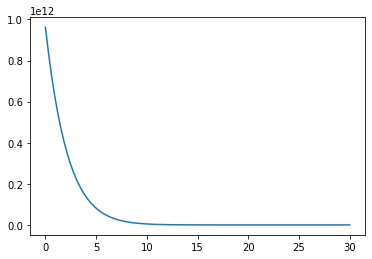

In [8]:
nevins_density_profile = density_profile.NevinsDensityProfile(1, 1, 2, 2, n_0)
psibars = np.linspace(0, 1.05, 100)
# plt.plot(nevins_density_profile.get_density_profile(psibars))
nevins_density_profile_callable = interp1d(psibars, nevins_density_profile.get_density_profile(psibars), bounds_error=False, fill_value='extrapolate')
tau_e = -0.08 # ms
timesteps = np.linspace(0, 30, 100) # ms 

rates = []
for timestep in timesteps:
    temp_profile_at_timestep = lambda x: flat_temperature_profile(x) * np.exp(tau_e * timestep)
    rates.append(calculate_neutron_rate(test_equil, nevins_density_profile_callable, temp_profile_at_timestep))

plt.plot(timesteps, rates)

In [3]:
def calc_neutron_spectrometer_output(f, chord_r1, chord_z1, chord_r2, chord_z2,
        density_psibar_profile: Callable[[float], float], temperature_psibar_profile: Callable[[float], float], 
        num_chord_points=1000):
    chord_rs = np.linspace(chord_r1, chord_r2, num_chord_points)
    chord_zs = np.linspace(chord_z1, chord_z2, num_chord_points)
    chord_mean_dL = np.mean((np.diff(chord_rs)**2 + np.diff(chord_zs)**2)**0.5)


    psibar_along_chord = np.array([f.second_order_mesh.interpolate_psi(chord_r, chord_z)
                            for chord_r, chord_z in zip(chord_rs, chord_zs)])
    T_along_chord = np.array([temperature_psibar_profile(psibar) for psibar in psibar_along_chord])
    n_along_chord = np.array([density_psibar_profile(psibar) for psibar in psibar_along_chord])

    # NRL plasma formulary reaction cross section
    # Parametrization good for T<25 keV, but underestimates a bit
    sigv_DD_along_chord = 2.33e-18 * T_along_chord**(-2/3) * np.exp(-187.6*T_along_chord**(-1/3))

    # Neutron luminosity [n/s/m^3]
    n_lum_along_chord = 0.25 * sigv_DD_along_chord * n_along_chord**2
    n_lum_along_chord[np.isnan(n_lum_along_chord)] = 0

    # collimator/NES active area radius # NES = neutron emission spectrometer
    R_COLLIMATOR = 7.5E-3 #[m]
    # distance from NES to plasma
    DIST_NES_PLASMA = 3 # [m]

    nes_neutron_flux_along_chord = n_lum_along_chord * (chord_mean_dL*np.pi*R_COLLIMATOR**2) * \
                                    (np.pi*R_COLLIMATOR**2/(4*np.pi*DIST_NES_PLASMA**2))
    nes_neutron_flux_total = np.sum(nes_neutron_flux_along_chord)

In [4]:
parser = FlagshipsParser('', 's000_bp0.00_dc-002_ab+0.0_c0.24_y05_i00.10.2023-10-12.hdf5')

calc_neutron_spectrometer_output(parser, .7, 0, .9, 0, flat_density_profile, flat_temperature_profile)

0.7 0.0
0.7002002002002001 0.0
0.7004004004004003 0.0
0.7006006006006006 0.0
0.7008008008008008 0.0
0.7010010010010009 0.0
0.7012012012012011 0.0
0.7014014014014014 0.0
0.7016016016016016 0.0
0.7018018018018017 0.0
0.7020020020020019 0.0
0.7022022022022022 0.0
0.7024024024024024 0.0
0.7026026026026025 0.0
0.7028028028028027 0.0
0.703003003003003 0.0
0.7032032032032032 0.0
0.7034034034034033 0.0
0.7036036036036035 0.0
0.7038038038038038 0.0
0.704004004004004 0.0
0.7042042042042042 0.0
0.7044044044044043 0.0
0.7046046046046046 0.0
0.7048048048048048 0.0
0.705005005005005 0.0
0.7052052052052051 0.0
0.7054054054054054 0.0
0.7056056056056056 0.0
0.7058058058058058 0.0
0.7060060060060059 0.0
0.7062062062062061 0.0
0.7064064064064064 0.0
0.7066066066066066 0.0
0.7068068068068067 0.0
0.7070070070070069 0.0
0.7072072072072072 0.0
0.7074074074074074 0.0
0.7076076076076075 0.0
0.7078078078078077 0.0
0.708008008008008 0.0
0.7082082082082082 0.0
0.7084084084084084 0.0
0.7086086086086085 0.0
0.70880

TypeError: unsupported operand type(s) for ** or pow(): 'list' and 'float'